# Extensions to Logistic Regression

In [1]:
using MLJ, Effects, MultipleTesting
using Econometrics, GLM
import AnovaGLM as aov
include("pubh.jl");

In [2]:
using AlgebraOfGraphics, CairoMakie, MakieThemes
CairoMakie.activate!(type = "svg")
AoG = AlgebraOfGraphics; data = AoG.data
set_theme!(ggthemr(:light))

In [3]:
@rlibrary readr
@rimport pubh

In [4]:
#| output: false
R"""
library(pubh)
library(sjlabelled)
""";

┌ Warning: RCall.jl: Loading required package: emmeans
│ Loading required package: ggformula
│ Loading required package: ggplot2
│ Loading required package: scales
│ Loading required package: ggridges
│ 
│ New to ggformula?  Try the tutorials: 
│ 	learnr::run_tutorial("introduction", package = "ggformula")
│ 	learnr::run_tutorial("refining", package = "ggformula")
│ Loading required package: gtsummary
│ Loading required package: huxtable
│ 
│ Attaching package: 'huxtable'
│ 
│ The following object is masked from 'package:gtsummary':
│ 
│     as_flextable
│ 
│ The following object is masked from 'package:scales':
│ 
│     number_format
│ 
│ The following object is masked from 'package:ggplot2':
│ 
│     theme_grey
│ 
│ Loading required package: magrittr
└ @ RCall /Users/josie/.julia/packages/RCall/gOwEW/src/io.jl:172
┌ Warning: RCall.jl: 
│ Attaching package: 'sjlabelled'
│ 
│ The following object is masked from 'package:huxtable':
│ 
│     set_label
│ 
│ The following object is masked 

## Interactions

We are going to look at a different way to test for interactions, try to think about biological interactions more than on statistical interactions.

::: callout-tip
## Example

We follow an example from Rothman regarding the effect of oral contraceptives and hypertension on strokes in young women.
:::

In [5]:
R"""
data(Rothman)

levels(Rothman$stroke) = c("No stroke", "Stroke")
levels(Rothman$ht) = c("No-Hypertension", "Hypertension")
""";

In [6]:
rothman = @rget Rothman
rothman |> head

Row,stroke,oc,ht
,Cat…,Cat…,Cat…
1,No stroke,Non-user,No-Hypertension
2,No stroke,Non-user,No-Hypertension
3,No stroke,Non-user,No-Hypertension
4,No stroke,Non-user,No-Hypertension
5,No stroke,Non-user,No-Hypertension


::: callout-caution
## Exercise

Perform descriptive statistics showing the distribution of stroke by hypertensive status and stratified by oral contraceptives usage.
:::

In [7]:
#| code-fold: true
#| output: asis
R"""
Rothman %>% 
  select(stroke, ht, oc) |> 
    mutate(
    stroke = relevel(stroke, ref = "Stroke"),
    ht = relevel(ht, ref = "Hypertension"),
    oc = relevel(oc, ref = "User")
  ) |> 
  copy_labels(Rothman) |> 
  tbl_strata(
    strata = oc,
    .tbl_fun = ~ .x |> 
      tbl_summary(by = ht, missing = "no")
  ) |>  
  cosm_sum(bold = TRUE) |> set_font_size(10) |> theme_pubh(2) |> 
  set_align(1, everywhere, "center") |>
  set_right_border(everywhere, 3) |>
  print_html()
""";

<table class="huxtable" style="border-collapse: collapse; border: 0px; margin-bottom: 2em; margin-top: 2em; ; margin-left: auto; margin-right: auto;  ">
<col><col><col><col><col><tr>
<th style="vertical-align: top; text-align: center; white-space: normal; border-style: solid solid solid solid; border-width: 0.4pt 0pt 0pt 0pt;    padding: 3pt 6pt 3pt 6pt; font-weight: bold; font-size: 10pt;"></th><th colspan="2" style="vertical-align: top; text-align: center; white-space: normal; border-style: solid solid solid solid; border-width: 0.4pt 0.4pt 0pt 0pt;    padding: 3pt 6pt 3pt 6pt; font-weight: bold; font-size: 10pt;"><p><strong>User</strong></p>
</th><th colspan="2" style="vertical-align: top; text-align: center; white-space: normal; border-style: solid solid solid solid; border-width: 0.4pt 0pt 0pt 0.4pt;    padding: 3pt 6pt 3pt 6pt; font-weight: bold; font-size: 10pt;"><p><strong>Non-user</strong></p>
</th></tr>
<tr>
<th style="vertical-align: top; text-align: left; white-space: norma

### Mantel-Haenszel approach

We can start with a stratified analysis (Mantel-Haenszel):

In [8]:
pubh.mhor(@formula(stroke ~ ht/oc), data = rothman) |> rcopy


                           OR Lower.CI Upper.CI Pr(>|z|)
htNo-Hypertension:ocUser 5.01     2.79     8.99  < 0.001
htHypertension:ocUser    3.78     1.60     8.94    0.002

                          Common OR Lower CI Upper CI Pr(>|z|)
Cochran-Mantel-Haenszel:       4.52     2.77     7.37  < 0.001

Test for effect modification (interaction): p =  0.6001 
 


::: callout-warning
## Question

What are your conclusions?
:::

::: callout-note
## Answer

The odds of having thrombotic stroke is 4.52 times more in users of oral contraceptives than in non-users (95% CIs: 2.77, 7.37) adjusted for history of hypertension. The effect of oral contraceptives on having  stroke is statistically significant ($p$ < 0.001) and is not different between women with a history of hypertension and women without history of hypertension (p = 0.600).
:::

### Statistical interactions

From the test of effect modification, we know that the interaction between use of oral contraceptives and history of hypertension was not significant. Let's compare with the logistic regression approach.

::: callout-important
Remember that for `glm` the outcome has to be an Integer.
:::

In [9]:
rothman.stroke_cont = coerce(rothman.stroke, Continuous) .- 1;

In [10]:
roth_1 = glm(@formula(stroke_cont ~ oc * ht), rothman, Binomial(), LogitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, LogitLink}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

stroke_cont ~ 1 + oc + ht + oc & ht

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────────
                                 Coef.  Std. Error       z  Pr(>|z|)  Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                  -1.84012     0.176846  -10.41    <1e-24   -2.18673  -1.49351
oc: User                      1.61054     0.298618    5.39    <1e-07    1.02526   2.19582
ht: Hypertension              1.49045     0.266309    5.60    <1e-07    0.96849   2.0124
oc: User & ht: Hypertension  -0.280045    0.530405   -0.53    0.5975   -1.31962   0.759529
─────────────────────────────────────────────────────────────────────────────────

Corresponding OR:

In [11]:
r3.(exp.(roth_1 |> coef))[2:4]

3-element Vector{Float64}:
 5.006
 4.439
 0.756

::: callout-caution
## Exercise

Construct the effect plot of oral contraceptive usage by history of hypertension.
:::

┌ Warning: Keyword argument `bgcolor` is deprecated, use `backgroundcolor` instead.
└ @ Makie /Users/josie/.julia/packages/Makie/RgxaV/src/makielayout/blocks/legend.jl:23


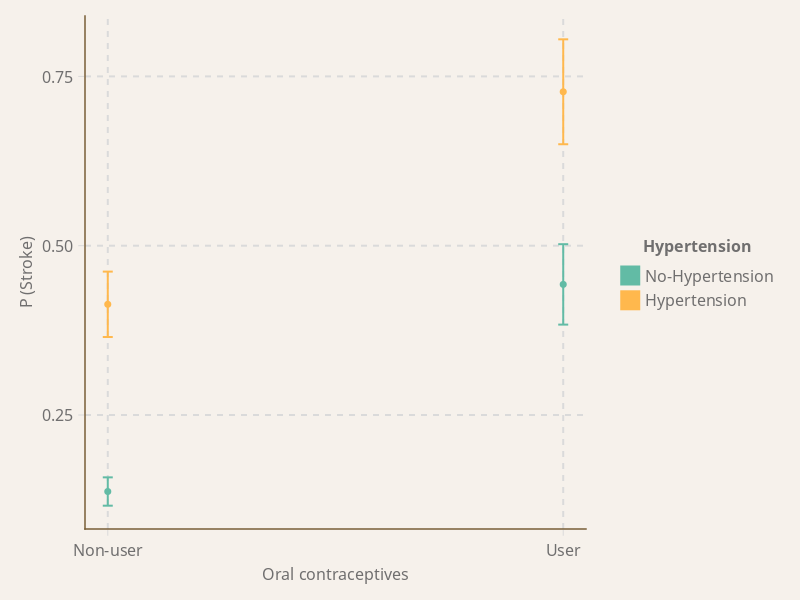

In [12]:
#| label: fig-fig1
#| fig-cap: "Effect of oral contraceptive usage on the probability of developing stroke, by history of hypertension."
#| warning: false
eff_1 = effects(
    Dict(
        :ht => levels(rothman.ht),
        :oc => levels(rothman.oc)
    ),
    roth_1, invlink=inv_logit
)

data(eff_1) *
mapping(
    :oc => sorter(levels(rothman.oc)) => "Oral contraceptives",
    :stroke_cont => "P (Stroke)",
    color = :ht => sorter(levels(rothman.ht)) => "Hypertension"
) *
(
    visual(Scatter, markersize=10) +
    mapping(:err) *
    visual(Errorbars, whiskerwidth=10)
) |>
draw

#### Joined exposures

The $p$−value of the interaction term ($p$ = 0.598) is the same as the test of homogeneity (if robust standard errors are not used). 

From a epidemiological (biological) point of view, we might be interested in testing what is the effect of both oral contraceptive use and history of hypertension (exposure) on stroke. We can generate a new variable (join) with different levels of exposure (based upon the combinations):

In [13]:
rothman.join .= 0
n = nrow(rothman)

for i in 1:n
  if rothman.oc[i] == "Non-user" && rothman.ht[i] == "Hypertension"
    rothman.join[i] = 1
  elseif rothman.oc[i] == "User" && rothman.ht[i] == "No-Hypertension"
    rothman.join[i] = 2
  elseif rothman.oc[i] == "User" && rothman.ht[i] == "Hypertension"
    rothman.join[i] = 3
  else
    rothman.join[i] = 0
  end
end

rothman.join = recode(
  rothman.join,
  0 => "Unexposed",
  1 => "Hypertension",
  2 => "OC user",
  3 => "OC+hypertension"
)

coerce!(rothman, :join => Multiclass)
levels!(rothman.join, ["Unexposed", "Hypertension", "OC user", "OC+hypertension"])

tabulate(rothman, :join)

                | Freq. | Percent |  Cum.   
--------------------------------------------
      Unexposed |   270 |  56.604 |  56.604 
   Hypertension |   104 |  21.803 |  78.407 
        OC user |    70 |  14.675 |  93.082 
OC+hypertension |    33 |   6.918 | 100.000 
--------------------------------------------
          Total |   477 | 100.000 |         


Now, we perform the logistic regression using `join` as our only predictor:

In [14]:
roth_2 = glm(@formula(stroke_cont ~ join), rothman, Binomial(), LogitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, LogitLink}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

stroke_cont ~ 1 + join

Coefficients:
───────────────────────────────────────────────────────────────────────────────────
                          Coef.  Std. Error       z  Pr(>|z|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────────────────
(Intercept)            -1.84012    0.176846  -10.41    <1e-24   -2.18673   -1.49351
join: Hypertension      1.49045    0.266309    5.60    <1e-07    0.96849    2.0124
join: OC user           1.61054    0.298618    5.39    <1e-07    1.02526    2.19582
join: OC+hypertension   2.82095    0.428702    6.58    <1e-10    1.98071    3.66118
───────────────────────────────────────────────────────────────────────────────────

Corresponding OR:

In [15]:
r3.(exp.(roth_2 |> coef))[2:4]

3-element Vector{Float64}:
  4.439
  5.006
 16.793

Look at the odds ratios. The join exposure has about 3 times more the effect of the single exposures. We can look at the trend in odds.

In [16]:
R"""
stroke_df = odds_trend(stroke ~ join, data = $rothman)$df
""";

In [17]:
@rget stroke_df

Row,Exposure,OR,lower,upper,chi_square,fisher_exact
,Cat…,Float64,Float64?,Float64?,String?,String?
1,Unexposed,1.0,missing,missing,missing,missing
2,Hypertension,4.44,2.63,7.48,< 0.001,< 0.001
3,OC user,5.01,2.79,8.99,< 0.001,< 0.001
4,OC+hypertension,16.79,7.24,38.94,< 0.001,< 0.001


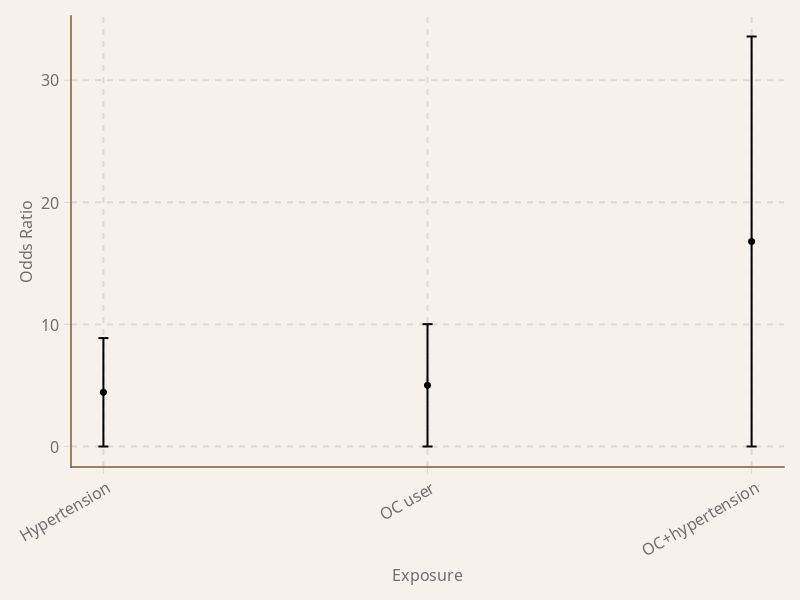

In [18]:
#| label: fig-fig2
#| fig-cap: "Effect of different levels of exposure on thrombotic stroke."
let
  plt = data(stroke_df |> dropmissing) *
  mapping(
  :Exposure => sorter(unique(stroke_df.Exposure)),
  :OR => "Odds Ratio"
  ) *
  (
  visual(Scatter, markersize=10) + 
  mapping(:OR) * 
  visual(Errorbars, whiskerwidth=10)
  )
  draw(plt, axis=(; xticklabelrotation=pi/6))
end

Is the trend significant?

In [19]:
roth_2 |> aov.anova

Analysis of Variance

Type 1 test / Likelihood-ratio test

stroke_cont ~ 1 + join

Table:
──────────────────────────────────────────────
             DOF  Deviance       χ²  Pr(>|χ²|)
──────────────────────────────────────────────
(Intercept)    1    568.38  92.8864     <1e-21
join           3    491.60  76.7794     <1e-15
──────────────────────────────────────────────



Why do we have different results regarding the interaction term? Because we are testing different things. The first model, `roth_1`, is testing if the effect of oral contraceptives use on stroke is different between women with a history of hypertension and women without a history of hypertension; that was not the case. The second model, `roth_2`, is testing if both the use of oral contraceptives and history of hypertension has an effect on stroke, and that was the case. Strictly speaking, our second model is not looking for interaction, but the effect of a combination of predictors.

The results from the second model, show that women with a history of hypertension and who are users of oral contraceptives are 16.79 times more likely to have stroke than unexposed women (OR: 16.79, 95% CIs: 5.62, 50.17) vs. the unexposed group ($p$ < 0.001). 

## Conditional Logistic Regression

Conditional logistic regression is used for matched case-control studies.

Matching is a way of controlling for confounding during the design stage of the study. Each case is paired with one or more controls according to levels of specified predictors.

::: callout-tip
## Example

We will look at a matched case-control study investigating the association between the use of oestrogen and endometrial cancer. Four controls were matched to each case by age and marital status.
:::

In [20]:
R"""
data(bdendo, package = "Epi")

bdendo = bdendo |>
mutate(
    cancer = factor(d, labels = c('Control', 'Case')),
    gall = factor(gall, labels = c("No GBD", "GBD")),
    est = factor(est, labels = c("No oestrogen", "Oestrogen"))
  ) |>
  var_labels(
    cancer = 'Endometrial cancer',
    gall = 'Gall bladder disease',
    est = 'Oestrogen'
  )
""";

In [21]:
@rget bdendo
bdendo |> schema

┌──────────┬───────────────────────────────┬────────────────────────────────────
│ names    │ scitypes                      │ types                             ⋯
├──────────┼───────────────────────────────┼────────────────────────────────────
│ set      │ Continuous                    │ Float64                           ⋯
│ d        │ Continuous                    │ Float64                           ⋯
│ gall     │ Multiclass{2}                 │ CategoricalValue{String, UInt32}  ⋯
│ hyp      │ Multiclass{2}                 │ CategoricalValue{String, UInt32}  ⋯
│ ob       │ Union{Missing, Multiclass{2}} │ Union{Missing, CategoricalValue{S ⋯
│ est      │ Multiclass{2}                 │ CategoricalValue{String, UInt32}  ⋯
│ dur      │ Union{Missing, Multiclass{5}} │ Union{Missing, CategoricalValue{S ⋯
│ non      │ Multiclass{2}                 │ CategoricalValue{String, UInt32}  ⋯
│ duration │ Union{Missing, Continuous}    │ Union{Missing, Float64}           ⋯
│ age      │ Continuous     

In [22]:
coerce!(bdendo, :set => Multiclass);

::: callout-caution
## Exercise

Perform descriptive analysis to show the distribution of endometrial cancer by gall bladder disease stratified by oral contraceptive usage.
:::

In [23]:
#| output: asis
#| code-fold: true
R"""
bdendo |> 
  select(cancer, gall, est) |> 
    mutate(
    cancer = relevel(cancer, ref = "Case"),
    gall = relevel(gall, ref = "GBD"),
    est = relevel(est, ref = "Oestrogen")
  ) |>
  copy_labels(bdendo) |>
  tbl_strata(
    strata = gall,
    .tbl_fun = ~ .x |>
      tbl_summary(by = est, missing = "no")
  ) |> 
  cosm_sum(bold = TRUE) |> set_font_size(10) |> theme_pubh(2) |> 
  set_align(1, everywhere, "center") |>
  set_right_border(everywhere, 3) |>
  print_html()
""";

<table class="huxtable" style="border-collapse: collapse; border: 0px; margin-bottom: 2em; margin-top: 2em; ; margin-left: auto; margin-right: auto;  ">
<col><col><col><col><col><tr>
<th style="vertical-align: top; text-align: center; white-space: normal; border-style: solid solid solid solid; border-width: 0.4pt 0pt 0pt 0pt;    padding: 3pt 6pt 3pt 6pt; font-weight: bold; font-size: 10pt;"></th><th colspan="2" style="vertical-align: top; text-align: center; white-space: normal; border-style: solid solid solid solid; border-width: 0.4pt 0.4pt 0pt 0pt;    padding: 3pt 6pt 3pt 6pt; font-weight: bold; font-size: 10pt;"><p><strong>GBD</strong></p>
</th><th colspan="2" style="vertical-align: top; text-align: center; white-space: normal; border-style: solid solid solid solid; border-width: 0.4pt 0pt 0pt 0.4pt;    padding: 3pt 6pt 3pt 6pt; font-weight: bold; font-size: 10pt;"><p><strong>No GBD</strong></p>
</th></tr>
<tr>
<th style="vertical-align: top; text-align: left; white-space: normal; 

### Unadjusted analysis

We will start with the unadjusted analysis.

In [24]:
using MixedModels

In [25]:
endom_1 = fit(
  MixedModel,
  @formula(d ~ 1 + est + (1 | set)),
  bdendo, Bernoulli()
);

In [26]:
endom_1 |> println

Generalized Linear Mixed Model fit by maximum likelihood (nAGQ = 1)
  d ~ 1 + est + (1 | set)
  Distribution: 

Bernoulli{Float64}
  Link: 

LogitLink()

   logLik    deviance     AIC       AICc        BIC    
  -140.0738   280.1476   286.1476   286.2247   297.4053



Variance components:
       Column   VarianceStd.Dev.
set (Intercept)  0.0 0.0

 Number of obs: 315; levels of grouping factors: 63

Fixed-effects parameters:


─────────────────────────────────────────────────────
                   Coef.  Std. Error      z  Pr(>|z|)
─────────────────────────────────────────────────────
(Intercept)     -2.88238    0.3884    -7.42    <1e-12
est: Oestrogen   2.06355    0.420221   4.91    <1e-06
─────────────────────────────────────────────────────


In [27]:
exp.(coef(endom_1))[2] |> r3

7.874

Corresponding 95% CI:

In [28]:
exp(coef(endom_1)[2] - 1.96*0.420221) |> r3, exp(coef(endom_1)[2] + 1.96*0.420221) |> r3

(3.455, 17.943)

::: callout-warning
## Question

What are your conclusions?
:::

::: callout-note
## Answer

When not adjusting for confounders, the odds of developing endometrial cancer is 7.87 times more (95% CIs: 3.46, 17.94) in women with a history of oestrogen use in comparison to women without a history of oestrogen use ($p$ < 0.001).
:::

### Adjusted analysis

Effect of oestrogen use on endometrial cancer controlling for history of gall bladder disease.

In [29]:
endom_2 = fit(
  MixedModel,
  @formula(d ~ est * gall + (1 | set)),
  bdendo, Binomial()
);

In [30]:
endom_2 |> println

Generalized Linear Mixed Model fit by maximum likelihood (nAGQ = 1)
  d ~ 1 + est + gall + est & gall + (1 | set)
  Distribution: Bernoulli{Float64}
  Link: LogitLink()

   logLik    deviance     AIC       AICc        BIC    
  -132.8141   265.6281   275.6281   275.8223   294.3910

Variance components:
       Column   VarianceStd.Dev.
set (Intercept)  0.0 0.0

 Number of obs: 315; levels of grouping factors: 63

Fixed-effects parameters:
─────────────────────────────────────────────────────────────────
                               Coef.  Std. Error      z  Pr(>|z|)
─────────────────────────────────────────────────────────────────
(Intercept)                 -3.66339    0.584657  -6.27    <1e-09
est: Oestrogen               2.71511    0.611627   4.44    <1e-05
gall: GBD                    2.97034    0.846647   3.51    0.0005
est: Oestrogen & gall: GBD  -2.22968    0.942602  -2.37    0.0180
─────────────────────────────────────────────────────────────────


In [31]:
r3.(exp.(coef(endom_2)))

4-element Vector{Float64}:
  0.026
 15.106
 19.499
  0.108

We can understand better the interaction term by looking at its corresponding effect plot.

Creating data frame for effect plot:

In [32]:
endom_eff = effects(
  Dict(
    :est => levels(bdendo.est),
    :gall => levels(bdendo.gall)
  ),
endom_2, invlink=inv_logit
)

Row,est,gall,d,err,lower,upper
,String,String,Float64,Float64,Float64,Float64
1,No oestrogen,No GBD,0.0250042,0.0142534,0.0107509,0.0392576
2,Oestrogen,No GBD,0.27923,0.0361509,0.24308,0.315381
3,No oestrogen,GBD,0.333356,0.136085,0.197271,0.469442
4,Oestrogen,GBD,0.448281,0.0923496,0.355931,0.54063


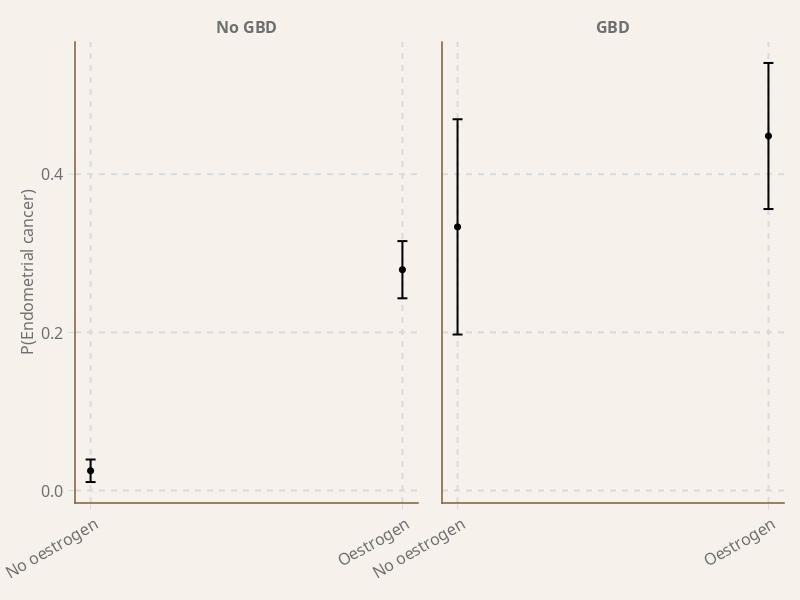

In [33]:
#| label: fig-fig3
#| fig-cap: "Effect of oestrogen on endometrial cancer by gall bladder disease (GBD)."
begin
  plt = data(endom_eff) *
  mapping(
    :est => sorter(levels(bdendo.est)) => "",
    :d => "P(Endometrial cancer)",
    layout = :gall => sorter(levels(bdendo.gall))
  ) *
  (
    visual(Scatter, markersize=10) +
    mapping(:err) *
    visual(Errorbars, whiskerwidth=10)
  )
  draw(plt, axis=(; xticklabelrotation=pi/6))
end

::: callout-warning
## Question

What are your conclusions from the interaction plot?
:::

::: callout-note
## Answer

In women without a history of gall bladder disease, oestrogen consumers are more likely to develop endometrial cancer than non-oestrogen consumers; i.e., oestrogen use has a positive effect on the development of endometrial cancer. In women with a history of gall bladder disease, there is no significant effect of oestrogen consumption in the development of endometrial cancer.
:::

## Ordinal Logistic Regression

So far, we have considered situations where the outcome was binary. What analysis do we perform if the outcome has more than two categories and is ordinal?

Examples of ordinal variables:

- The level of agreement: strongly disagree, disagree, neutral, agree, strongly agree.
- A form of disease: mild, moderate, severe.

::: callout-tip
## Example

We will use data from a questionnaire on the benefits of mammography. 
:::

In [34]:
mammo = rcopy(R"TH.data::mammoexp")
mammo |> head

Row,ME,SYMPT,PB,HIST,BSE,DECT
,Cat…,Cat…,Int64,Cat…,Cat…,Cat…
1,Never,Disagree,7,No,Yes,Somewhat likely
2,Never,Agree,11,No,Yes,Very likely
3,Never,Disagree,8,Yes,Yes,Very likely
4,Within a Year,Disagree,11,No,Yes,Very likely
5,Over a Year,Strongly Disagree,7,No,Yes,Very likely


Our outcome of interest is `ME` (mammography experience), and ordinal variable.

In [35]:
tabulate(mammo, :ME)

              | Freq. | Percent |  Cum.   
------------------------------------------
        Never |   234 |  56.796 |  56.796 
Within a Year |   104 |  25.243 |  82.039 
  Over a Year |    74 |  17.961 | 100.000 
------------------------------------------
        Total |   412 | 100.000 |         


If $y$ is the ordinal outcome with levels $1,2,\dots,k$, then the proportional odds ordinal logistic model can be written as a series of logistic models:

$$
\begin{gather}
 P(y>1) & = & \text{logit}^{-1}(\beta x) \\
 P(y>2) & = & \text{logit}^{-1}(\beta x - c_2) \\
 \vdots & & \vdots \\
 P(y>[k-1]) & = & \text{logit}^{-1}(\beta x - c_{k-1})
\end{gather}
$$

Hence $e^{\beta}$ is the odds ratio of being in a higher category for a one unit change in the predictor variable.

When we have three groups, we are comparing: unlikely vs. (somewhat likely and very likely) and (unlikely and somewhat likely) vs. (very likely).

With the proportional odds assumption (parallel regression assumption) we assume that the relationship between each pair of outcome groups is the same. Hence, there is only one model. If this assumption did not hold, we would need different models to describe the relationship between each pair of outcome variables. We should test this hypothesis before we report the results.

::: callout-important
For the model to work, the response variable has to be defined as an `OrderedFactor`.
:::

In [36]:
coerce!(
  mammo,
  :ME => OrderedFactor,
  :SYMPT => OrderedFactor
  );

In [37]:
mammo_1 = fit(
  EconometricModel,
  @formula(ME ~ SYMPT + PB + HIST + BSE + DECT),
  mammo
)

Probability Model for Ordinal Response
Categories: Never < Within a Year < Over a Year
Number of observations: 412
Null Loglikelihood: -402.60
Loglikelihood: -363.56
R-squared: 0.0970
LR Test: 78.08 ∼ χ²(8) ⟹ Pr > χ² = 0.0000
Formula: ME ~ SYMPT + PB + HIST + BSE + DECT
──────────────────────────────────────────────────────────────────────────────────────────────────────────
                                              PE         SE       t-value  Pr > |t|      2.50%      97.50%
──────────────────────────────────────────────────────────────────────────────────────────────────────────
SYMPT: Agree                              -0.126848  0.548065   -0.231446    0.8171  -1.20426    0.950568
SYMPT: Disagree                            1.20629   0.462617    2.60754     0.0095   0.296855   2.11573
SYMPT: Strongly Disagree                   1.4707    0.464212    3.16818     0.0017   0.558133   2.38328
PB                                        -0.15037   0.0572979  -2.62436     0.0090  -0.2630

Let's remove `DECT` from the model:

In [38]:
mammo_2 = fit(
  EconometricModel,
  @formula(ME ~ SYMPT + PB + HIST + BSE),
  mammo
)

Probability Model for Ordinal Response
Categories: Never < Within a Year < Over a Year
Number of observations: 412
Null Loglikelihood: -402.60
Loglikelihood: -364.96
R-squared: 0.0935
LR Test: 75.27 ∼ χ²(6) ⟹ Pr > χ² = 0.0000
Formula: ME ~ SYMPT + PB + HIST + BSE
─────────────────────────────────────────────────────────────────────────────────────────────────────────
                                              PE        SE       t-value  Pr > |t|      2.50%      97.50%
─────────────────────────────────────────────────────────────────────────────────────────────────────────
SYMPT: Agree                              -0.120306  0.548382  -0.219384    0.8265  -1.19833    0.957716
SYMPT: Disagree                            1.27483   0.458285   2.78175     0.0057   0.373924   2.17574
SYMPT: Strongly Disagree                   1.53564   0.458085   3.3523      0.0009   0.635125   2.43616
PB                                        -0.153462  0.05573   -2.75367     0.0062  -0.263018  -0.0439069

We will create a data frame with the table of coefficients.

In [39]:
mammo_coef = coeftable(mammo_2) |> DataFrame
mammo_coef |> head

Row,Name,PE,SE,t-value,Pr > |t|,2.50%,97.50%
,String,Float64,Float64,Float64,Float64,Float64,Float64
1,SYMPT: Agree,-0.120306,0.548382,-0.219384,0.826461,-1.19833,0.957716
2,SYMPT: Disagree,1.27483,0.458285,2.78175,0.00565878,0.373924,2.17574
3,SYMPT: Strongly Disagree,1.53564,0.458085,3.3523,0.000876605,0.635125,2.43616
4,PB,-0.153462,0.05573,-2.75367,0.00615776,-0.263018,-0.0439069
5,HIST: Yes,0.771167,0.300763,2.56403,0.0107054,0.179919,1.36241


Corresponding table of coefficients showing Odds Ratios and confindence intervals:

In [40]:
mammo_exp = @chain mammo_coef begin
  select(1, 2, 6, 7, 5)
end;

In [41]:
mammo_exp[:, 2] = r3.(exp.(mammo_exp[:, 2]))
mammo_exp[:, 3] = r3.(exp.(mammo_exp[:, 3]))
mammo_exp[:, 4] = r3.(exp.(mammo_exp[:, 4]))
mammo_exp

Row,Name,PE,2.50%,97.50%,Pr > |t|
,String,Float64,Float64,Float64,Float64
1,SYMPT: Agree,0.887,0.302,2.606,0.826461
2,SYMPT: Disagree,3.578,1.453,8.809,0.00565878
3,SYMPT: Strongly Disagree,4.644,1.887,11.429,0.000876605
4,PB,0.858,0.769,0.957,0.00615776
5,HIST: Yes,2.162,1.197,3.906,0.0107054
6,BSE: Yes,2.817,1.323,5.999,0.00737782
7,(Intercept): Never | Within a Year,3.451,0.888,13.409,0.0735626
8,(Intercept): Within a Year | Over a Year,14.231,3.598,56.287,0.000169216
